In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product



In [2]:
from sklearn import ensemble, metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import validation_curve

## Load data

In [4]:
train = pd.read_csv("data/sales_train.csv")
test = pd.read_csv("data/test.csv")
shops = pd.read_csv("data/shops.csv")
item_cats = pd.read_csv("data/item_categories.csv")
items = pd.read_csv("data/items.csv")



In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000,1.000
1,03.01.2013,0,25,2552,899.000,1.000
2,05.01.2013,0,25,2552,899.000,-1.000
3,06.01.2013,0,25,2554,"1,709.050",1.000
4,15.01.2013,0,25,2555,"1,099.000",1.000


In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


## Preprocessing

In [52]:
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']
train.drop_duplicates(subset=subset, inplace=True)
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()
train = train[train.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_format
0,02.01.2013,0,59,22154,999.000,1.000,2013-01-02
10,03.01.2013,0,25,2574,399.000,2.000,2013-01-03
11,05.01.2013,0,25,2574,399.000,1.000,2013-01-05
12,07.01.2013,0,25,2574,399.000,1.000,2013-01-07
13,08.01.2013,0,25,2574,399.000,2.000,2013-01-08


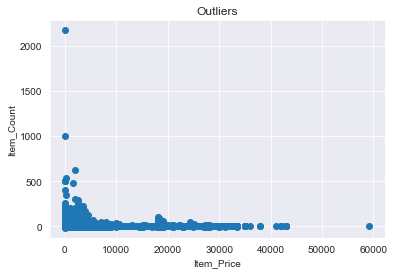

In [53]:
plt.title('Outliers')
plt.xlabel('Item_Price')
plt.ylabel('Item_Count')
plt.scatter(x= train.item_price, y= train.item_cnt_day)

plt.show()


In [59]:
train['date_format'] = pd.to_datetime(train.date,format='%d.%m.%Y')


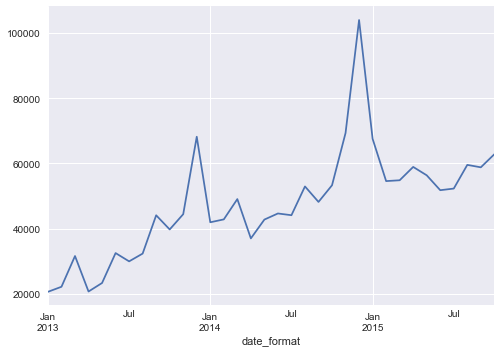

In [60]:
plt.style.use('seaborn')

train.copy().set_index('date_format').item_cnt_day.resample('M') \
                            .sum().plot();

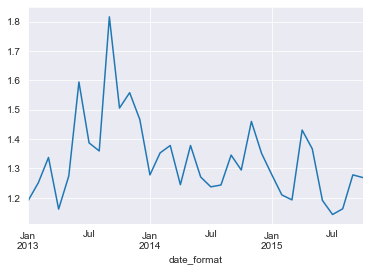

In [46]:
train.copy().set_index('date_format').item_cnt_day.resample('M') \
                            .mean().plot();

In [61]:

# create all combinations
block_shop_combi = pd.DataFrame(list(product(np.arange(34), test_shops)), columns=['date_block_num','shop_id'])
shop_item_combi = pd.DataFrame(list(product(test_shops, test_items)), columns=['shop_id','item_id'])
all_combi = pd.merge(block_shop_combi, shop_item_combi, on=['shop_id'], how='inner')
print(len(all_combi), 34 * len(test_shops) * len(test_items))

# group by monthly
train_base = pd.merge(all_combi, train, on=['date_block_num','shop_id','item_id'], how='left')
train_base['item_cnt_day'].fillna(0, inplace=True)
train_grp = train_base.groupby(['date_block_num','shop_id','item_id'])

train_grp.head(5)


7282800 7282800


,date_block_num,shop_id,item_id,date,item_price,item_cnt_day,date_format
0,0,5,5037,NaN,nan,0.000,NaT
1,0,5,5320,NaN,nan,0.000,NaT
2,0,5,5233,NaN,nan,0.000,NaT
3,0,5,5232,NaN,nan,0.000,NaT
4,0,5,5268,NaN,nan,0.000,NaT
...,...,...,...,...,...,...,...
7907065,33,45,18454,30.10.2015,99.000,1.000,2015-10-30
7907066,33,45,16188,NaN,nan,0.000,NaT
7907067,33,45,15757,NaN,nan,0.000,NaT
7907068,33,45,19648,NaN,nan,0.000,NaT


## Mean Encoding

In [55]:
# summary count by month
train_monthly = pd.DataFrame(train_grp.agg({'item_cnt_day':['sum','count']})).reset_index()
train_monthly.columns = ['date_block_num','shop_id','item_id','item_cnt','item_order']

train_monthly.head()
# trim count
train_monthly['item_cnt'].clip(0, 20, inplace=True)



### Feature creation

In [56]:
# pickup first category name
item_grp = item_cats['item_category_name'].apply(lambda x: str(x).split(' ')[0])
item_cats['item_group'] = pd.Categorical(item_grp).codes
#item_cats = item_cats.join(pd.get_dummies(item_grp, prefix='item_group', drop_first=True))
items = pd.merge(items, item_cats.loc[:,['item_category_id','item_group']], on=['item_category_id'], how='left')

city = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(city).codes



In [58]:
# By shop,item
grp = train_monthly.groupby(['shop_id', 'item_id'])
train_shop = grp.agg({'item_cnt':['mean','median','std'],'item_order':'mean'}).reset_index()
train_shop.columns = ['shop_id','item_id','cnt_mean_shop','cnt_med_shop','cnt_std_shop','order_mean_shop']

train_shop.head()
train_cat_monthly = pd.merge(train_monthly, items, on=['item_id'], how='left')
grp = train_cat_monthly.groupby(['shop_id', 'item_group'])
train_shop_cat = grp.agg({'item_cnt':['mean']}).reset_index()
train_shop_cat.columns = ['shop_id','item_group','cnt_mean_shop_cat']

train_shop_cat.head()

,shop_id,item_group,cnt_mean_shop_cat
0,2,0,0.000
1,2,1,0.352
2,2,3,0.000
3,2,4,0.196
4,2,5,0.292


### Lag features

In [16]:
# By month,shop,item At previous
train_prev = train_monthly.copy()
train_prev['date_block_num'] = train_prev['date_block_num'] + 1
train_prev.columns = ['date_block_num','shop_id','item_id','cnt_prev','order_prev']

for i in [2,12]:
    train_prev_n = train_monthly.copy()
    train_prev_n['date_block_num'] = train_prev_n['date_block_num'] + i
    train_prev_n.columns = ['date_block_num','shop_id','item_id','cnt_prev' + str(i),'order_prev' + str(i)]
    train_prev = pd.merge(train_prev, train_prev_n, on=['date_block_num','shop_id','item_id'], how='left')

train_prev.head()

,date_block_num,shop_id,item_id,cnt_prev,order_prev,cnt_prev2,order_prev2,cnt_prev12,order_prev12
0,1,2,30,0.000,1,nan,nan,nan,nan
1,1,2,31,0.000,1,nan,nan,nan,nan
2,1,2,32,0.000,1,nan,nan,nan,nan
3,1,2,33,1.000,1,nan,nan,nan,nan
4,1,2,38,0.000,1,nan,nan,nan,nan


In [17]:
# By month,shop,item_group At previous
grp = pd.merge(train_prev, items, on=['item_id'], how='left').groupby(['date_block_num','shop_id','item_group'])
train_cat_prev = grp['cnt_prev'].mean().reset_index()
train_cat_prev = train_cat_prev.rename(columns={'cnt_prev':'cnt_prev_cat'})
train_cat_prev.head()

,date_block_num,shop_id,item_group,cnt_prev_cat
0,1,2,0,0.000
1,1,2,1,0.280
2,1,2,3,0.000
3,1,2,4,0.000
4,1,2,5,0.100


In [18]:
train_piv = train_monthly.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values='item_cnt', aggfunc=np.sum, fill_value=0)
train_piv = train_piv.reset_index()
train_piv.head()

# MACD At previous
col = np.arange(34)
pivT = train_piv[col].T
ema_s = pivT.ewm(span=4).mean().T
ema_m = pivT.ewm(span=12).mean().T
ema_l = pivT.ewm(span=26).mean().T
macd = ema_s - ema_l
sig = macd.ewm(span=9).mean()

ema_list = []
for c in col:
  sub_ema = pd.concat([train_piv.loc[:,['shop_id','item_id']],
      pd.DataFrame(ema_s.loc[:,c]).rename(columns={c:'cnt_ema_s_prev'}),
      pd.DataFrame(ema_m.loc[:,c]).rename(columns={c:'cnt_ema_m_prev'}),
      pd.DataFrame(ema_l.loc[:,c]).rename(columns={c:'cnt_ema_l_prev'}),
      pd.DataFrame(macd.loc[:,c]).rename(columns={c:'cnt_macd_prev'}),
      pd.DataFrame(sig.loc[:,c]).rename(columns={c:'cnt_sig_prev'})], axis=1)
  sub_ema['date_block_num'] = c + 1
  ema_list.append(sub_ema)
    
train_ema_prev = pd.concat(ema_list)
train_ema_prev.head()

,shop_id,item_id,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,date_block_num
0,2,30,0.000,0.000,0.000,0.000,0.000,1
1,2,31,0.000,0.000,0.000,0.000,0.000,1
2,2,32,0.000,0.000,0.000,0.000,0.000,1
3,2,33,1.000,1.000,1.000,0.000,0.000,1
4,2,38,0.000,0.000,0.000,0.000,0.000,1


### Item prices

In [20]:
# Price mean by month,shop,item
train_price = train_grp['item_price'].mean().reset_index()
price = train_price[~train_price['item_price'].isnull()]

# last price by shop,item
last_price = price.drop_duplicates(subset=['shop_id', 'item_id'], keep='last').drop(['date_block_num'], axis=1)

# null price by shop,item

uitem = price['item_id'].unique()
pred_price_set = test[~test['item_id'].isin(uitem)].drop('ID', axis=1)

if len(pred_price_set) > 0:
    train_price_set = pd.merge(price, items, on=['item_id'], how='inner')
    pred_price_set = pd.merge(pred_price_set, items, on=['item_id'], how='inner').drop(['item_name'], axis=1)
    reg = ensemble.ExtraTreesRegressor(n_estimators=25, n_jobs=-1, max_depth=15, random_state=42)
    reg.fit(train_price_set[pred_price_set.columns], train_price_set['item_price'])
    pred_price_set['item_price'] = reg.predict(pred_price_set)

test_price = pd.concat([last_price, pred_price_set], join='inner')
test_price.head()

,shop_id,item_id,item_price
209,2,1204,299.000
211,2,1224,399.000
219,2,1247,299.000
826,2,3656,299.000
1064,2,4531,279.000


### Discount rate

In [21]:
price_max = price.groupby(['item_id']).max()['item_price'].reset_index()
price_max.rename(columns={'item_price':'item_max_price'}, inplace=True)
price_max.head()

,item_id,item_max_price
0,30,399.000
1,31,699.000
2,32,349.000
3,33,499.000
4,38,"2,399.000"


In [22]:
train_price_a = pd.merge(price, price_max, on=['item_id'], how='left')
train_price_a['discount_rate'] = 1 - (train_price_a['item_price'] / train_price_a['item_max_price'])
train_price_a.drop('item_max_price', axis=1, inplace=True)
train_price_a.head()

,date_block_num,shop_id,item_id,item_price,discount_rate
0,0,2,33,499.000,0.000
1,0,2,482,"3,300.000",0.000
2,0,2,491,600.000,0.000
3,0,2,839,"3,300.000",0.000
4,0,2,1007,449.000,0.626


In [23]:
test_price_a = pd.merge(test_price, price_max, on=['item_id'], how='left')
test_price_a.loc[test_price_a['item_max_price'].isnull(), 'item_max_price'] = test_price_a['item_price']
test_price_a['discount_rate'] = 1 - (test_price_a['item_price'] / test_price_a['item_max_price'])
test_price_a.drop('item_max_price', axis=1, inplace=True)
test_price_a.head()

,shop_id,item_id,item_price,discount_rate
0,2,1204,299.000,0.000
1,2,1224,399.000,0.111
2,2,1247,299.000,0.000
3,2,3656,299.000,0.143
4,2,4531,279.000,0.067


## Data preparation

## Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage


In [24]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [25]:
def mergeFeature(df): 
  df = pd.merge(df, items, on=['item_id'], how='left').drop('item_group', axis=1)
  df = pd.merge(df, item_cats, on=['item_category_id'], how='left')
  df = pd.merge(df, shops, on=['shop_id'], how='left')

  df = pd.merge(df, train_shop, on=['shop_id','item_id'], how='left')
  df = pd.merge(df, train_shop_cat, on=['shop_id','item_group'], how='left')
  df = pd.merge(df, train_prev, on=['date_block_num','shop_id','item_id'], how='left')
  df = pd.merge(df, train_cat_prev, on=['date_block_num','shop_id','item_group'], how='left')
  df = pd.merge(df, train_ema_prev, on=['date_block_num','shop_id','item_id'], how='left')
  
  df['month'] = df['date_block_num'] % 12
  days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
  df['days'] = df['month'].map(days).astype(np.int8)
  
  df.drop(['shop_id','shop_name','item_id','item_name','item_category_id','item_category_name','item_group'], axis=1, inplace=True)
  df.fillna(0.0, inplace=True)
  return reduce_mem_usage(df)

In [26]:
train_set = train_monthly[train_monthly['date_block_num'] >= 12]

train_set = pd.merge(train_set, train_price_a, on=['date_block_num','shop_id','item_id'], how='left')
train_set = mergeFeature(train_set)
train_set = train_set.join(pd.DataFrame(train_set.pop('item_order'))) # move to last column

# train_set.head()
X_train = train_set.drop(['item_cnt'], axis=1)
#Y_train = train_set['item_cnt']
Y_train = train_set['item_cnt'].clip(0,20)
# X_train.head()

Memory usage of dataframe is 871.85 MB --> 404.47 MB (Decreased by 53.6%)


In [27]:
X_train.head()

,date_block_num,item_price,discount_rate,city,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop,cnt_mean_shop_cat,cnt_prev,...,order_prev12,cnt_prev_cat,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,month,days,item_order
0,12,0.000,0.000,0,0.118,0.000,0.327,1.000,0.039,0.000,...,1.000,0.040,0.023,0.105,0.139,-0.116,-0.116,0,31,1
1,12,0.000,0.000,0,0.235,0.000,0.741,1.088,0.039,0.000,...,1.000,0.040,0.020,0.220,0.355,-0.335,-0.238,0,31,1
2,12,119.000,0.659,0,0.324,0.000,0.638,1.088,0.039,0.000,...,1.000,0.040,0.000,0.000,0.000,0.000,-0.140,0,31,1
3,12,199.000,0.601,0,0.324,0.000,0.535,1.029,0.039,1.000,...,1.000,0.040,0.883,0.507,0.403,0.480,0.070,0,31,1
4,12,0.000,0.000,0,0.000,0.000,0.000,1.000,0.039,0.000,...,1.000,0.040,0.000,0.000,0.000,0.000,0.049,0,31,1


In [28]:
Y_train.head()

0   0.000
1   0.000
2   1.000
3   1.000
4   0.000
Name: item_cnt, dtype: float32

In [29]:
X_train.shape

(4712400, 24)

In [30]:
test_set = test.copy()
test_set['date_block_num'] = 34

test_set = pd.merge(test_set, test_price_a, on=['shop_id','item_id'], how='left')
test_set = mergeFeature(test_set)
test_set['item_order'] = test_set['cnt_ema_s_prev'] #order_prev
test_set.loc[test_set['item_order'] == 0, 'item_order'] = 1

X_test = test_set.drop(['ID'], axis=1)
X_test.head()


Memory usage of dataframe is 38.00 MB --> 18.18 MB (Decreased by 52.2%)


,date_block_num,item_price,discount_rate,city,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop,cnt_mean_shop_cat,cnt_prev,...,order_prev12,cnt_prev_cat,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,month,days,item_order
0,34,749.500,0.712,3,0.382,0.000,0.739,1.118,0.274,0.000,...,1.000,0.378,0.856,0.871,0.674,0.182,-0.212,10,30,0.856
1,34,308.627,0.000,3,0.000,0.000,0.000,1.000,0.094,0.000,...,1.000,0.104,0.000,0.000,0.000,0.000,-0.216,10,30,1.000
2,34,"1,199.000",0.000,3,0.294,0.000,0.799,1.118,0.274,1.000,...,1.000,0.378,1.461,1.016,0.651,0.810,0.147,10,30,1.461
3,34,599.000,0.500,3,0.029,0.000,0.171,1.000,0.274,0.000,...,1.000,0.378,0.144,0.111,0.069,0.075,-0.019,10,30,0.144
4,34,"2,206.158",0.000,3,0.000,0.000,0.000,1.000,0.274,0.000,...,1.000,0.378,0.000,0.000,0.000,0.000,-0.034,10,30,1.000


In [31]:
test_set.shape

(214200, 25)

In [32]:
from sklearn.model_selection import train_test_split
trn_x, val_x, trn_y, val_y = train_test_split(X_train,Y_train)

In [33]:
trn_y.shape
trn_x.iloc[:,0].shape

(3534300,)

# Prediction with Linear Regression 

In [34]:


lr = LinearRegression()
lr.fit(trn_x, trn_y)

preds_trn = lr.predict(trn_x)
preds_val = lr.predict(val_x)

print('RMSE_TRAIN:' ,np.sqrt(mean_squared_error(trn_y,preds_trn)))
print('RMSE_VAL:', np.sqrt(mean_squared_error(val_y,preds_val)))


preds_test = lr.predict(X_test).clip(0,20)


linear_reg_df = pd.DataFrame()
linear_reg_df['ID'] = test['ID']

linear_reg_df['item_cnt_month'] = preds_test

linear_reg_df.to_csv('linear_submission.csv',index=False)



del linear_reg_df

RMSE_TRAIN: 0.36753094
RMSE_VAL: 0.36544836


# Model2- Lightbgm

Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 0.153654	valid_0's rmse: 0.189044
[1000]	training's rmse: 0.13748	valid_0's rmse: 0.186258
[1500]	training's rmse: 0.126688	valid_0's rmse: 0.18463
[2000]	training's rmse: 0.11872	valid_0's rmse: 0.183748
[2500]	training's rmse: 0.112606	valid_0's rmse: 0.18335
Early stopping, best iteration is:
[2930]	training's rmse: 0.107936	valid_0's rmse: 0.183027


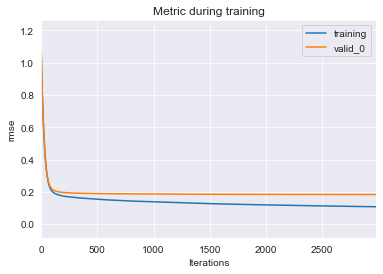

In [35]:
from sklearn import linear_model, preprocessing
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

params={'learning_rate': 0.03,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 64,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 1,
        'feature_fraction': 1
       }

reg = lgb.LGBMRegressor(**params, n_estimators=3000)
reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y),(trn_x, trn_y)], early_stopping_rounds=50, verbose=500)
# print(reg.evals_result_)
lgb.plot_metric(reg)

preds_test = reg.predict(X_test).clip(0,20)


lgb_reg_df = pd.DataFrame()
lgb_reg_df['ID'] = test['ID']

lgb_reg_df['item_cnt_month'] = preds_test

lgb_reg_df.to_csv('lgb_submission.csv',index=False)

del lgb_reg_df


# Model 3- XGBoost

[0]	validation_0-rmse:0.97533	validation_1-rmse:0.96951
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.83661	validation_1-rmse:0.83385
[2]	validation_0-rmse:0.72280	validation_1-rmse:0.72040
[3]	validation_0-rmse:0.62776	validation_1-rmse:0.62562
[4]	validation_0-rmse:0.54754	validation_1-rmse:0.54659
[5]	validation_0-rmse:0.48141	validation_1-rmse:0.48100
[6]	validation_0-rmse:0.42783	validation_1-rmse:0.42750
[7]	validation_0-rmse:0.38378	validation_1-rmse:0.38395
[8]	validation_0-rmse:0.34717	validation_1-rmse:0.34864
[9]	validation_0-rmse:0.31805	validation_1-rmse:0.32016
[10]	validation_0-rmse:0.29603	validation_1-rmse:0.29834
[11]	validation_0-rmse:0.27740	validation_1-rmse:0.28040
[12]	validation_0-rmse:0.26241	validation_1-rmse:0.26595
[13]	validation_0-rmse:0.25135	validation_1-rmse:0.25527
[14]	validation_0-rmse:0.24245	validation_1-rmse:0.24

[141]	validation_0-rmse:0.17748	validation_1-rmse:0.19657
[142]	validation_0-rmse:0.17723	validation_1-rmse:0.19649
[143]	validation_0-rmse:0.17718	validation_1-rmse:0.19649
[144]	validation_0-rmse:0.17714	validation_1-rmse:0.19650
[145]	validation_0-rmse:0.17708	validation_1-rmse:0.19645
[146]	validation_0-rmse:0.17692	validation_1-rmse:0.19631
[147]	validation_0-rmse:0.17653	validation_1-rmse:0.19592
[148]	validation_0-rmse:0.17651	validation_1-rmse:0.19591
[149]	validation_0-rmse:0.17610	validation_1-rmse:0.19571
[150]	validation_0-rmse:0.17601	validation_1-rmse:0.19564
[151]	validation_0-rmse:0.17597	validation_1-rmse:0.19563
[152]	validation_0-rmse:0.17587	validation_1-rmse:0.19562
[153]	validation_0-rmse:0.17579	validation_1-rmse:0.19562
[154]	validation_0-rmse:0.17572	validation_1-rmse:0.19561
[155]	validation_0-rmse:0.17558	validation_1-rmse:0.19553
[156]	validation_0-rmse:0.17555	validation_1-rmse:0.19555
[157]	validation_0-rmse:0.17548	validation_1-rmse:0.19557
[158]	validati

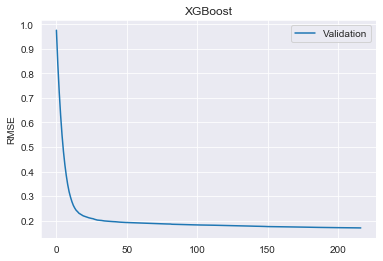

In [36]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from matplotlib import pyplot


Train = xgb.DMatrix(trn_x, trn_y)
Val = xgb.DMatrix(val_x, val_y)

model = XGBRegressor(
    max_depth=6,
    n_estimators=2000,
    min_child_weight=30, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.15,    
    seed=42)

model.fit(
    trn_x, 
    trn_y, 
    eval_metric="rmse", 
    eval_set=[(trn_x, trn_y), (val_x, val_y)], 
    verbose=True, 
    early_stopping_rounds = 10)

preds_test = model.predict(X_test).clip(0,20)

xg_boost = pd.DataFrame()
xg_boost['ID'] = test['ID']

# xgb.plot_metric(model)

xg_boost['item_cnt_month'] = preds_test

xg_boost.to_csv('xgb_submission.csv',index=False)

results = model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Validation')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost')
pyplot.show()


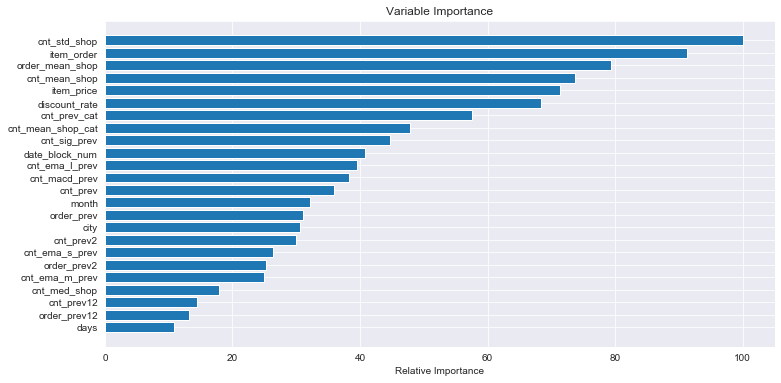

In [37]:
# Plot feature importance for LIGHTBGM
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()